In [13]:
! pip install transformers tensorboardX datasets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [14]:
# from google.colab import drive
# drive.mount('/content/drive')

In [15]:
PROJECT_DIR = './'

In [16]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
from datasets import load_dataset
emotions = load_dataset("emotion")

In [18]:
emotions.set_format(type="pandas")
df = emotions["train"][:]

In [19]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [20]:
df['label_name'] = df['label'].apply(lambda x: emotions["train"].features["label"].int2str(x))

In [21]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Exploratory Data Analysis

/var/folders/2l/l_lnhh8n4y3c6tw0v92pbxf80000gn/T/ipykernel_20900/1115163482.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_name', data=df, palette='crest')


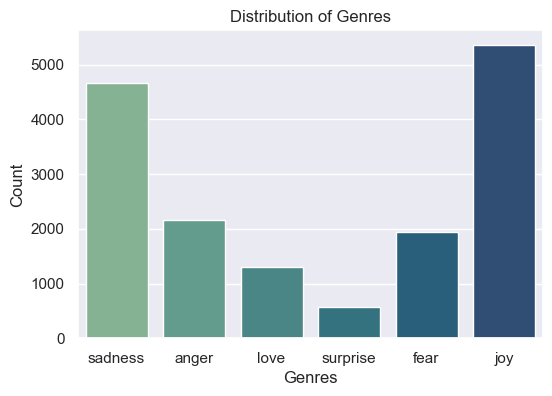

In [22]:
sns.set(style="darkgrid")
plt.figure(figsize=(6, 4))
sns.countplot(x='label_name', data=df, palette='crest')
plt.title('Distribution of Genres')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.show()

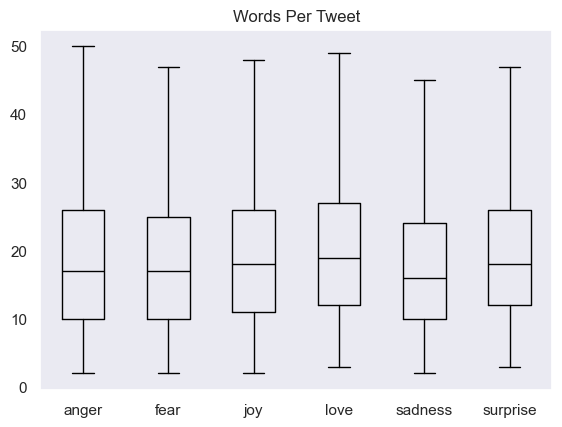

In [23]:
df['Words Per Tweet'] = df['text'].str.split().apply(lambda x: len(x))
df.boxplot("Words Per Tweet", by="label_name", grid=False,
              showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [24]:
df.head()

,text,label,label_name,Words Per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


## Transformer from scratch

In [25]:
import numpy as np

In [26]:
class InputEmbedding(nn.Module):
    def __init__(self, model_dim, vocab_size):
        super().__init__()
        self.model_dim = model_dim
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, model_dim)

    def forward(self, x):
        return self.embedding(x) * np.sqrt(self.model_dim)

In [27]:
class PositionalEmbedding(nn.Module):
    def __init__(self, model_dim, seq_len, dropout):
        super().__init__()
        self.model_dim = model_dim
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)

        pos_embed = torch.zeros(seq_len, model_dim)
        positions = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        denom = torch.exp(torch.arange(0, model_dim, 2, dtype=torch.float)*(np.log(10000.0)/model_dim))

        pos_embed[:, 0::2] = torch.sin(positions * denom)
        pos_embed[:, 1::2] = torch.cos(positions * denom)

        pos_embed = pos_embed.unsqueeze(0) # (1, seq_len, model_dim)

        self.register_buffer('pos_embed', pos_embed)

    def forward(self, x):
        x = x + (self.pos_embed[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)

In [28]:
class LayerNormalization(nn.Module):
    def __init__(self, eps = 10**-6):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(1)) # Multiplicative
        self.beta =  nn.Parameter(torch.zeros(1)) # Additive

    def forward(self, x):
        # x is (batch_size, seq_len, embed_dim)
        mean = x.mean(dim = -1, keepdim = True)
        std = x.std(dim = -1, keepdim = True)
        return self.gamma * (x-mean)/(std+self.eps) + self.beta

In [29]:
class FeedForward(nn.Module):
    def __init__(self, model_dim, out_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(model_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(out_dim, model_dim)

    def forward(self, x):
        # (batch, seq_len, embed_dim) -> (batch, seq_len, out_dim) -> (batch, seq_len, embed_dim)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [30]:
class MultiHeadAttention(nn.Module):
    def __init__(self, model_dim, num_heads, dropout):
        super().__init__()
        self.model_dim = model_dim
        self.heads = num_heads
        assert model_dim % num_heads == 0, "Embedding dimension is not divisible by number of heads"

        self.head_dim = model_dim//num_heads

        self.w_q = nn.Linear(model_dim, model_dim)
        self.w_k = nn.Linear(model_dim, model_dim)
        self.w_v = nn.Linear(model_dim, model_dim)

        self.w_o = nn.Linear(model_dim, model_dim)
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        head_dim = query.shape[-1]

        # Matrix multiplication of
        # (batch, num_heads, seq_len, head_dim) x (batch, num_heads, head_dim, seq_len) --> (batch, num_heads, seq_len, seq_len)

        attention_scores = (query @ key.transpose(-2, -1))/np.sqrt(head_dim)

        if mask is not None:
            expanded_mask = mask.unsqueeze(1).unsqueeze(2).expand_as(attention_scores)
            attention_scores.masked_fill_(expanded_mask == 0, -1e9)

        attention_scores = attention_scores.softmax(dim = -1) #(batch, num_heads, seq_len, seq_len)

        if dropout is not None:
            attention_scores = dropout(attention_scores)

        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        # (batch, seq_l, embed_dim)
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_v(v)

        # (batch, seq_len, embed_dim) -> (batch, seq_len, num_heads, head_dim) -> (batch, num_heads, seq_len, head_dim)
        query = query.view(query.shape[0], query.shape[1], self.heads, self.head_dim).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.heads, self.head_dim).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.heads, self.head_dim).transpose(1, 2)

        x, self.attention_scores = MultiHeadAttention.attention(query, key, value, mask, self.dropout)

        # (batch, num_heads, seq_len, head_dim) -> (batch, seq_len, num_heads, head_dim) -> (batch, seq_len, embed_dim)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.heads*self.head_dim)

        # (batch, seq_len, embed_dim) -> (batch, seq_len, embed_dim)
        return self.w_o(x)

In [31]:
class ResidualConnection(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization()

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [32]:
class EncoderBlock(nn.Module):
    def __init__(self, self_attention_block: MultiHeadAttention, feed_forward: FeedForward, dropout: float):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [33]:
class Encoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.layer_norm = LayerNormalization()

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.layer_norm(x)

In [34]:
import torch.nn.functional as F

class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # x = F.softmax(x, dim=1)
        return x

In [35]:
class Model(nn.Module):
    def __init__(self,
                 input_embedding: InputEmbedding,
                 pos_embedding: PositionalEmbedding,
                 encoder: Encoder,
                 mlp: MultiLayerPerceptron,
                 ):
        super().__init__()
        self.encoder = encoder
        self.input_embedding = input_embedding
        self.position_embedding = pos_embedding
        self.mlp = mlp

    def forward(self, x, attention_mask):
        x = self.input_embedding(x)
        x = self.position_embedding(x)
        x = self.encoder(x, attention_mask)
        x = self.mlp(x[:, 0])
        return x

In [36]:
from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import json

In [37]:
class MyDataset(Dataset):
    def __init__(self, tokenized_texts, encoded_labels):
        self.tokenized_texts = tokenized_texts
        self.encoded_labels = encoded_labels

    def __len__(self):
        return len(self.tokenized_texts["input_ids"])

    def __getitem__(self, idx):
        return {
            "input_ids": self.tokenized_texts["input_ids"][idx],
            "attention_mask": self.tokenized_texts["attention_mask"][idx],
            "labels": torch.tensor(self.encoded_labels[idx], dtype=torch.float32),
        }

In [38]:
def prepare_data(input_list, encoded_labels, config):

    meta_data = {}

    if config["tokenizer"] == 'bert_tokenizer':
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        meta_data['vocab_size'] = tokenizer.vocab_size
    else:
        raise Exception("Unknown Tokenizer")

    tokenized_texts = tokenizer(input_list, padding='max_length', truncation=True,
                                max_length=config["seq_len"], return_tensors='pt',
                                return_attention_mask='True')

    dataset = MyDataset(tokenized_texts, encoded_labels)
    dataloader = DataLoader(dataset, batch_size= config['batch_size'], shuffle=True)
    return dataloader, meta_data

In [39]:
import json

with open('config.json', 'r') as json_file:
    config = json.load(json_file)

In [40]:
from pathlib import Path

def get_weights_path(config, epoch):
    model_base = config["model_basename"]
    file_name = f'{model_base}epoch{epoch}.pth'
    return str(Path('.')/file_name)

In [41]:
get_weights_path(config, 10)

'emotion_model_epoch10.pth'

In [42]:
def build_model(vocab_size, seq_len,
                num_classes,
                embed_dim=512, num_heads = 8,
                num_encoders = 6,
                dropout = 0.1, encoder_ff_out_dim = 2048) -> Model:
    inp_embedding = InputEmbedding(embed_dim, vocab_size)
    pos_embedding = PositionalEmbedding(embed_dim, seq_len, dropout)

    encoder_blocks = []
    for _ in range(num_encoders):
        self_attention_block = MultiHeadAttention(embed_dim, num_heads, dropout)
        feed_forward = FeedForward(embed_dim, encoder_ff_out_dim, dropout)
        encoder_blocks.append(EncoderBlock(self_attention_block, feed_forward, dropout))

    encoder = Encoder(nn.ModuleList(encoder_blocks))

    mlp = MultiLayerPerceptron(embed_dim, 512, num_classes)

    return Model(inp_embedding, pos_embedding, encoder, mlp)


In [43]:
input_list = df['text'].tolist()

# Labels are already encoded
label_list = [[label] for label in df['label']]

dataloader, meta_data = prepare_data(input_list, label_list, config)

In [32]:
import torch.optim as optim
from tensorboardX import SummaryWriter
import os

def train(config):
    torch.cuda.empty_cache()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device {device}')

    writer = SummaryWriter()

    # input_list = dataframe['description'].tolist()
    # label_list = [[label] for label in dataframe['genre']]
    # label_encoder = OneHotEncoder(sparse=False)

    # dataloader, meta_data = prepare_data(input_list, label_list, label_encoder, config)

    print(config)
    model = build_model(
        meta_data['vocab_size'],
        config['seq_len'],
        config['num_classes'],
        config['embed_dim']
        )

    model = model.to(device)

    print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

    checkpoint_dir = PROJECT_DIR+config['model_folder']
    # os.makedirs(checkpoint_dir, exist_ok=True)

    should_preload = config['preload']

    if should_preload == "True":
        checkpoint_filename = get_weights_path(config, config['preload_epoch'])
        checkpoint = torch.load(checkpoint_dir+"/"+checkpoint_filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Loaded model weights!")

    NUM_EPOCHS = config['epochs']
    lr = config['learning_rate']
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(NUM_EPOCHS):
        model.train()

        total_loss = 0.0
        total_correct = 0

        for batch in dataloader:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["labels"]

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)

            labels = labels.squeeze().type(torch.int64)

            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)

            total_correct += (predicted == labels).sum().item()

            total_loss += loss.item()

        average_loss = total_loss / len(dataloader)
        accuracy = total_correct / len(dataloader.dataset)

        print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]")
        print(f"Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")

        checkpoint_filename = os.path.join(checkpoint_dir, f'{config["model_basename"]}{epoch+1}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
        }, checkpoint_filename)

        writer.add_scalar("Training Loss", average_loss, epoch)
        writer.add_scalar("Training Accuracy", accuracy, epoch)

    writer.close()

    return model

In [33]:
# model = train(config=config)

Using device cuda
{'batch_size': 64, 'learning_rate': 0.0005, 'seq_len': 256, 'epochs': 5, 'num_classes': 6, 'embed_dim': 512, 'tokenizer': 'bert_tokenizer', 'model_folder': 'weights', 'model_basename': 'emotion_model_', 'preload': 'False', 'preload_epoch': None}
Model has 34795040 parameters
Epoch [1/5]
Loss: 1.1422, Accuracy: 56.01%
Epoch [2/5]
Loss: 0.4532, Accuracy: 83.85%
Epoch [3/5]
Loss: 0.3128, Accuracy: 88.26%
Epoch [4/5]
Loss: 0.2311, Accuracy: 91.11%
Epoch [5/5]
Loss: 0.1935, Accuracy: 92.51%


In [44]:
test_data = emotions["test"]["text"].tolist()
test_label = emotions["test"]["label"].tolist()

In [45]:
testdataloader, meta_data = prepare_data(test_data, test_label, config)

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

Using device cpu


In [68]:
def get_model_with_weights(config):
    model = build_model(
        meta_data['vocab_size'],
        config['seq_len'],
        config['num_classes'],
        config['embed_dim']
        )

    checkpoint_filename = get_weights_path(config, 5)
    checkpoint_filename = config['model_folder']+"/"+checkpoint_filename
    checkpoint = torch.load(checkpoint_filename, map_location=torch.device(device))
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

In [50]:
def test(model, dataloader, device):
    
    model.eval()

    total_correct = 0

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device {device}')

    preds = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["labels"]

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            labels = labels.squeeze().type(torch.int64)

            outputs = model(input_ids, attention_mask)

            _, predicted = torch.max(outputs, 1)

            preds.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            total_correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {total_correct / len(dataloader.dataset) * 100:.2f}%")
    return preds, true_labels

In [69]:
model = get_model_with_weights(config)

In [51]:
predictions, labels = test(model, testdataloader, device)

Using device cpu
Test Accuracy: 88.10%


In [53]:
prediction_label_names = emotions["test"].features["label"].int2str(predictions)
true_label_names = emotions["test"].features["label"].int2str(labels)

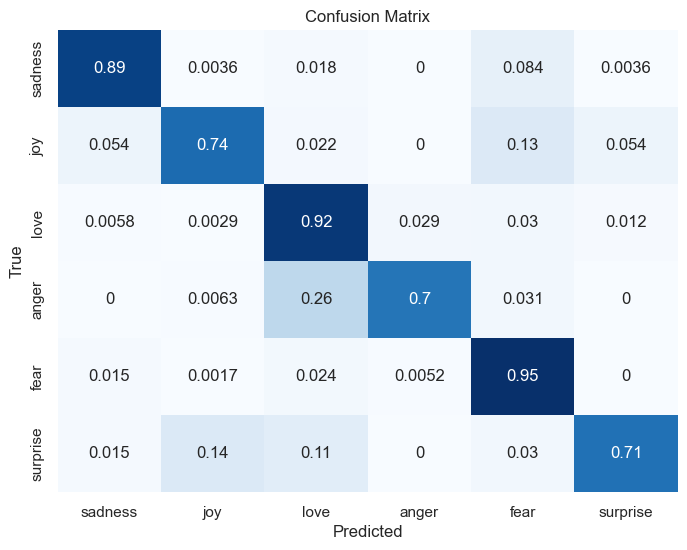

In [67]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(true_label_names, prediction_label_names)
normalized_confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

class_names = emotions["test"].features["label"].names

plt.figure(figsize=(8, 6))
sns.set(font_scale=1)
sns.heatmap(normalized_confusion, annot=True, cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [70]:
def get_idx_label_mapping():
    idx_label_map = {}
    for i, emotion in enumerate(emotions["test"].features["label"].names):
        idx_label_map[i] = emotion
    return idx_label_map

In [71]:
label_mapping = get_idx_label_mapping()

In [73]:
def inference(input, model, label_mapping):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokenized_text = tokenizer(input, padding='max_length', truncation=True,
                                max_length=config["seq_len"], return_tensors='pt',
                                return_attention_mask='True')
    tokenized_input = tokenized_text["input_ids"]
    attention_mask = tokenized_text["attention_mask"]

    return model(tokenized_input, attention_mask), label_mapping 

In [100]:
output, label_mapping = inference("I hate this. I am annoyed that I had to pay so much for this crap!", model, label_mapping)

In [101]:
print(torch.argmax(output), label_mapping)

tensor(3) {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
